## 从单变量情形开始，探究LP方法的效果，及Optimal Transport方法的实现

模型设计：

X[1]=1

X[2] = Uniform(0,1)

Y=X[2]+X[2]*Uniform(0,1)+7

Q_Y(t)=7 X[1]+(1+t)X[2]

## 对每一个分位数t，都进行一次计算，观察效果。也就是，不考虑单调性约束。

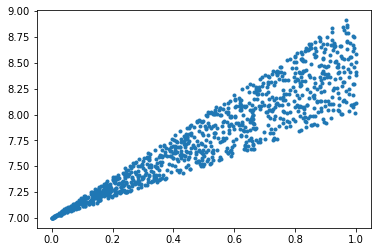

In [2]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

SAMPLE_AMOUNT = 1000
X2 = np.random.uniform(0,1,SAMPLE_AMOUNT)

EPSILON = np.random.uniform(0,1,SAMPLE_AMOUNT)

Y = X2 + X2 * EPSILON + 7

plt.plot(X2,Y,'.')

In [2]:
def para_solver(t):
    m = Model()
    
    beta = [m.add_var(name = "beta") for i in range(2)]
    
    epsilon_pos = [m.add_var(lb=0) for i in range(SAMPLE_AMOUNT)]
    
    epsilon_neg = [m.add_var(lb=0) for i in range(SAMPLE_AMOUNT)]
    
    for i in range(SAMPLE_AMOUNT):
        m += epsilon_pos[i] - epsilon_neg[i] - Y[i] + beta[0] + X2[i]*beta[1] == 0
        
    m.objective = minimize(xsum( t * epsilon_pos[i] + (1-t) * epsilon_neg[i] for i in range(SAMPLE_AMOUNT)))
    
    status = m.optimize(max_seconds=300)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        
    else:
        count = 1
        for v in m.vars: 
            if v.name == "beta":
                print("beta "+str(count)+" :"+str(v.x))
                count += 1
    return m
                
solved_model = para_solver(0.4)
   
    
    

beta 1 :6.995697058462757
beta 2 :1.4215383467458147


## 看起来还是蛮准确的，但是这里我们更加关心对偶程序的解，a，及统计量rank score, 所以这就需要重新设计模型了

模型设计：

X[1]=1

X[2] = Uniform(0,1)

X[3] = Normal(0,1)

X[4] = 1/Sqrt[2] X[3] + 1/Sqrt[2] Normal(0,1)

Y= 3 + 5 X[2] +  Normal(0,1)

phi(t) = t^2, A(phi)^2 = 4/45

既然模型下H0假设(beta[3]=beta[4]=0)成立，我们希望验证rank score的行为是否符合预期

考虑进行1000次实验

每次实验，生成2000个样本，并均匀选取50个t水平，在每个t水平下计算对偶变量a，这样就可以算出目标统计量。我们来看这100个样本是不是大概是 chi_2^2的分布

In [6]:
from numpy.linalg import inv
import time

EXP_TIMES = 1000
TIME_LEVELS = 50
SAMPLE_AMOUNT = 2000

collection = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0
for exp in range(EXP_TIMES):
    # generate
    X2 = np.random.uniform(0,1,SAMPLE_AMOUNT)
    X3 = np.random.normal(0,1,SAMPLE_AMOUNT)
    
    X4_aid = np.random.normal(0,1,SAMPLE_AMOUNT)
    X4 = 1/np.sqrt(2) * X3 + 1/np.sqrt(2) * X4_aid
    
    X_3and4 = np.column_stack((X3, X4))
    
    EPSI = np.random.normal(0,1,SAMPLE_AMOUNT)
    
    Y = 3 + 5*X2 + EPSI
    
    A = 4/45
    
    Q = 1/SAMPLE_AMOUNT * np.matmul(X_3and4.T,X_3and4)
    
    dual_data = np.zeros((TIME_LEVELS,SAMPLE_AMOUNT))
    
    for t in range(1,TIME_LEVELS+1):
        quantile = t / TIME_LEVELS
        
        # calculate dual
        
        a_s = np.zeros(SAMPLE_AMOUNT)
        
        
        m = Model()
    
        a = [m.add_var(lb=0,ub=1,name="a") for i in range(SAMPLE_AMOUNT)]
    
        m += xsum(a[i] for i in range(SAMPLE_AMOUNT)) == (1-quantile)*SAMPLE_AMOUNT
        m += xsum(a[i]*X2[i] for i in range(SAMPLE_AMOUNT)) == (1-quantile)*xsum(X2[i] for i in range(SAMPLE_AMOUNT))
        m += xsum(a[i]*X3[i] for i in range(SAMPLE_AMOUNT)) == (1-quantile)*xsum(X3[i] for i in range(SAMPLE_AMOUNT))
        m += xsum(a[i]*X4[i] for i in range(SAMPLE_AMOUNT)) == (1-quantile)*xsum(X4[i] for i in range(SAMPLE_AMOUNT))
         
        m.objective = maximize(xsum(Y[i] * a[i] for i in range(SAMPLE_AMOUNT)))
    
        status = m.optimize(max_seconds=300)
        
        if not status == OptimizationStatus.OPTIMAL:
            print("SOMETHING WRONG!")
            quit()

        else:
            count = 0
            for v in m.vars: 
                dual_data[t-1][count] = v.x
                count += 1
    
    # calculate target statistics
    b=0
    for t in range(1,TIME_LEVELS):
        b +=  (t/TIME_LEVELS)**2 * (dual_data[t] - dual_data[t-1])
        
        
        
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X_3and4.T,b)
    
    T_STAT = np.matmul(np.matmul(S.T,inv(Q)),S)/A
    
    collection[exp] = T_STAT
    
    batch += 1
    
    if batch == 10:
        print("experiment ",exp)
        batch = 0
    



experiment  9
experiment  19
experiment  29
experiment  39
experiment  49
experiment  59
experiment  69
experiment  79
experiment  89
experiment  99
experiment  109
experiment  119
experiment  129
experiment  139
experiment  149
experiment  159
experiment  169
experiment  179
experiment  189
experiment  199
experiment  209
experiment  219
experiment  229
experiment  239
experiment  249
experiment  259
experiment  269
experiment  279
experiment  289
experiment  299
experiment  309
experiment  319
experiment  329
experiment  339
experiment  349
experiment  359
experiment  369
experiment  379
experiment  389
experiment  399
experiment  409
experiment  419
experiment  429
experiment  439
experiment  449
experiment  459
experiment  469
experiment  479
experiment  489
experiment  499
experiment  509
experiment  519
experiment  529
experiment  539
experiment  549
experiment  559
experiment  569
experiment  579
experiment  589
experiment  599
experiment  609
experiment  619
experiment  629
exp

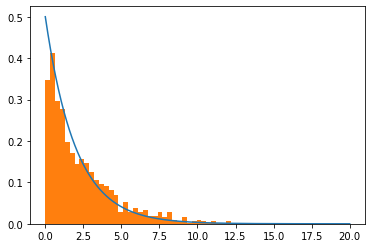

In [8]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0, 20, 0.001)

#plot Chi-square distribution with 4 degrees of freedom
plt.plot(x, chi2.pdf(x, df=2))

plt.hist(collection, density=True, bins=50)

plt.show()

## 看起来rank score的渐进长得也蛮像chi_2^2的，下面考虑加入单调性约束。也就是说，通过optimal transport的方法来求出密度pi，积分得到单调性约束下每个t对应的a，再计算rank score，然后再看看这个score是不是也有好的渐进性质呢？我们沿用上面的模型

In [2]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time

EXP_TIMES = 10
TIME_LEVELS = 50
SAMPLE_AMOUNT = 2000

collection = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0
for exp in range(EXP_TIMES):
    # generate
    X2 = np.random.uniform(0,1,SAMPLE_AMOUNT)
    X3 = np.random.normal(0,1,SAMPLE_AMOUNT)
    
    X4_aid = np.random.normal(0,1,SAMPLE_AMOUNT)
    X4 = 1/np.sqrt(2) * X3 + 1/np.sqrt(2) * X4_aid
    
    X_3and4 = np.column_stack((X3, X4))
    
    EPSI = np.random.normal(0,1,SAMPLE_AMOUNT)
    
    Y = 3 + 5*X2 + EPSI
    
    A = 4/45
    
    Q = 1/SAMPLE_AMOUNT * np.matmul(X_3and4.T,X_3and4)
    
    dual_density = np.zeros((TIME_LEVELS,SAMPLE_AMOUNT))
    
    
    m = Model()
    
    pi = [[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for t in range(TIME_LEVELS)]
    
    for t in range(TIME_LEVELS):
        m += xsum(pi[t][i] for i in range(SAMPLE_AMOUNT)) == SAMPLE_AMOUNT/TIME_LEVELS
        m += xsum(pi[t][i]*X2[i] for i in range(SAMPLE_AMOUNT)) == xsum(X2[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
        m += xsum(pi[t][i]*X3[i] for i in range(SAMPLE_AMOUNT)) == xsum(X3[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
        m += xsum(pi[t][i]*X4[i] for i in range(SAMPLE_AMOUNT)) == xsum(X4[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
   
    for n in range(SAMPLE_AMOUNT):
        m += xsum(pi[t][n] for t in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(xsum(xsum(t/TIME_LEVELS * Y[i] * pi[t-1][i] for i in range(SAMPLE_AMOUNT)) for t in range(1,TIME_LEVELS+1)))
    
    status = m.optimize(max_seconds=300)
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t=0
        i=0
        for v in m.vars: 
            dual_density[t][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t+=1
    
    # calculate target statistics
    b=0
    for t in range(1,TIME_LEVELS+1):
        b +=  (t/TIME_LEVELS)**2 * (dual_density[t-1])
        
        
        
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X_3and4.T,b)
    
    T_STAT = np.matmul(np.matmul(S.T,inv(Q)),S)/A
    
    collection[exp] = T_STAT
    
    print(time.time()-start_time)
    print(T_STAT)
    
    
    #batch += 1
    
    #if batch == 10:
    #    print("experiment ",exp)
    #    batch = 0

32.36323595046997
0.359038615100756
61.59457850456238
8.460163166602133


KeyboardInterrupt: 